# Images Classification with Convolutional Neural Networks & Keras

## Loading dataset to colab from drive

In [0]:
import os
import zipfile

local_zip = '/content/drive/My Drive/the-simpsons-characters-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

## Imports

In [0]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import pickle
import h5py
import sklearn
from sklearn.model_selection import train_test_split
from collections import Counter
import glob
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from random import shuffle
from keras.optimizers import SGD, Adam
import imp
import os
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
%matplotlib inline

## Data prep

In [0]:
# Creating dictionary of The Simpsons Characters from dataset with character that have more than 290 pictures
# characters = [k.split('/')[2] for k in glob.glob('./characters/*') if len([p for p in glob.glob(k+'/*') if 'edited' in p or 'pic_vid' in p]) > 290]
# map_characters = dict(enumerate(characters))
map_characters = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 
        3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
        7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
        11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
        14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'}

pic_size = 64
batch_size = 32
epochs = 200
num_classes = len(map_characters)
pictures_per_class = 1000
test_size = 0.15

In [0]:
# Load pictures from folders for characters from the map_characters dict and create a numpy dataset and 
# a numpy labels set. Pictures are re-sized into picture_size square.
def load_pictures():
    pics = []
    labels = []
    for k, char in map_characters.items():
        pictures = [k for k in glob.glob('/tmp/simpsons_dataset/%s/*' % char)]
        nb_pic = round(pictures_per_class/(1-test_size)) if round(pictures_per_class/(1-test_size))<len(pictures) else len(pictures)
        # nb_pic = len(pictures)
        for pic in np.random.choice(pictures, nb_pic):
            a = cv2.imread(pic)
#             if BGR:
#                 a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
            a = cv2.resize(a, (pic_size,pic_size))
            pics.append(a)
            labels.append(k)
    return np.array(pics), np.array(labels) 

In [10]:
# Create the actual dataset split into train and test, pictures content is as float32 and
#   normalized (/255.)
X, y = load_pictures()
y = keras.utils.to_categorical(y, num_classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
print("Train", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)
dist = {k:tuple(d[k] for d in [dict(Counter(np.where(y_train==1)[1])), dict(Counter(np.where(y_test==1)[1]))]) for k in range(num_classes)}
print('\n'.join(["%s : %d train pictures & %d test pictures" % (map_characters[k], v[0], v[1]) for k,v in sorted(dist.items(), key=lambda x:x[1][0], reverse=True)]))

Train (14317, 64, 64, 3) (14317, 18)
Test (2527, 64, 64, 3) (2527, 18)
bart_simpson : 1033 train pictures & 143 test pictures
marge_simpson : 1012 train pictures & 164 test pictures
lisa_simpson : 1002 train pictures & 174 test pictures
moe_szyslak : 1001 train pictures & 175 test pictures
ned_flanders : 987 train pictures & 189 test pictures
krusty_the_clown : 986 train pictures & 190 test pictures
principal_skinner : 986 train pictures & 190 test pictures
charles_montgomery_burns : 982 train pictures & 194 test pictures
homer_simpson : 959 train pictures & 217 test pictures
milhouse_van_houten : 926 train pictures & 153 test pictures
chief_wiggum : 836 train pictures & 150 test pictures
abraham_grampa_simpson : 790 train pictures & 123 test pictures
sideshow_bob : 760 train pictures & 117 test pictures
apu_nahasapeemapetilon : 538 train pictures & 85 test pictures
kent_brockman : 435 train pictures & 63 test pictures
comic_book_guy : 401 train pictures & 68 test pictures
edna_krabapp

## Training

### 4 convolutions

In [11]:
# CNN Keras model with 4 convolutions.

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.0002, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 64)       

In [0]:
datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images
# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(X_train)

In [14]:
history = model.fit_generator(datagen.flow(X_train, y_train,
                            batch_size=batch_size),
                            steps_per_epoch=X_train.shape[0] // batch_size,
                            epochs=100,
                            validation_data=(X_test, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/100





447/447 [==============================] - 33s 74ms/step - loss: 2.4013 - acc: 0.2603 - val_loss: 1.8257 - val_acc: 0.4753
Epoch 2/100
447/447 [==============================] - 26s 57ms/step - loss: 1.8752 - acc: 0.4455 - val_loss: 1.4353 - val_acc: 0.5940
Epoch 3/100
447/447 [==============================] - 26s 59ms/step - loss: 1.5557 - acc: 0.5362 - val_loss: 1.2291 - val_acc: 0.6383
Epoch 4/100
447/447 [==============================] - 25s 57ms/step - loss: 1.3614 - acc: 0.5947 - val_loss: 1.1046 - val_acc: 0.6842
Epoch 5/100
447/447 [==============================] - 26s 58ms/step - loss: 1.2097 - acc: 0.6383 - val_loss: 0.9433 - val_acc: 0.7388
Epoch 6/100
447/447 [==============================] - 25s 57ms/step - loss: 1.0950 - acc: 0.6745 - val_loss: 0.8444 - val_acc: 0.7554
Epoch 7/100
447/447 [==============================] - 27s 59ms/step - loss: 1.0116 - ac

### Analyzing

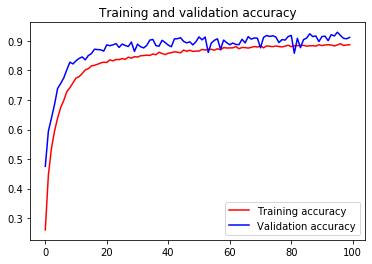

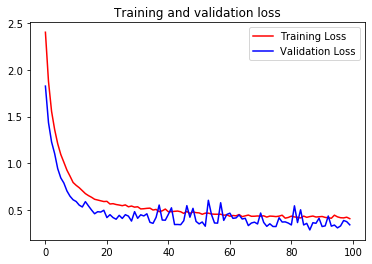

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
# Test the model
y_pred = model.predict(X_test)
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=list(map_characters.values())), sep='')


                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.86      0.95      0.90       123
  apu_nahasapeemapetilon       0.86      0.96      0.91        85
            bart_simpson       0.83      0.87      0.85       143
charles_montgomery_burns       0.88      0.94      0.91       194
            chief_wiggum       0.87      0.99      0.93       150
          comic_book_guy       0.88      0.75      0.81        68
          edna_krabappel       0.94      0.88      0.91        76
           homer_simpson       0.92      0.85      0.89       217
           kent_brockman       0.97      0.98      0.98        63
        krusty_the_clown       0.93      0.98      0.96       190
            lisa_simpson       0.86      0.90      0.88       174
           marge_simpson       0.99      0.92      0.96       164
     milhouse_van_houten       0.94      0.95      0.94       153
             moe_szyslak       0.95      0.82      0.88       175
        

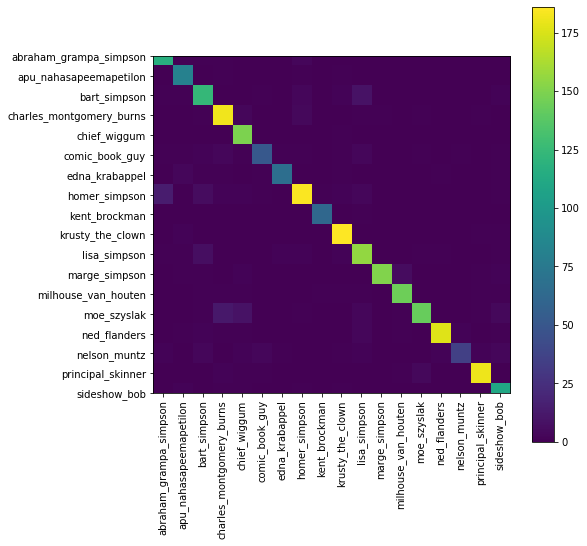

In [17]:
plt.figure(figsize=(8,8))
cnf_matrix = sklearn.metrics.confusion_matrix(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1))
classes = list(map_characters.values())
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

### 6 convolutions

In [0]:
# CNN Keras model with 6 convolutions.

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding='same')) 
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [25]:
history = model.fit_generator(datagen.flow(X_train, y_train,
                                    batch_size=batch_size),
                                    steps_per_epoch=X_train.shape[0] // batch_size,
                                    epochs=40,
                                    validation_data=(X_test, y_test))

Epoch 1/40
447/447 [==============================] - 29s 64ms/step - loss: 2.5657 - acc: 0.1958 - val_loss: 2.0511 - val_acc: 0.3914
Epoch 2/40
447/447 [==============================] - 28s 62ms/step - loss: 1.9768 - acc: 0.3934 - val_loss: 1.4529 - val_acc: 0.5694
Epoch 3/40
447/447 [==============================] - 28s 62ms/step - loss: 1.5202 - acc: 0.5349 - val_loss: 1.0315 - val_acc: 0.6874
Epoch 4/40
447/447 [==============================] - 28s 62ms/step - loss: 1.1792 - acc: 0.6407 - val_loss: 0.8184 - val_acc: 0.7582
Epoch 5/40
447/447 [==============================] - 28s 62ms/step - loss: 0.9476 - acc: 0.7074 - val_loss: 0.7279 - val_acc: 0.7859
Epoch 6/40
447/447 [==============================] - 28s 62ms/step - loss: 0.7879 - acc: 0.7573 - val_loss: 0.5830 - val_acc: 0.8290
Epoch 7/40
447/447 [==============================] - 27s 61ms/step - loss: 0.6813 - acc: 0.7927 - val_loss: 0.5676 - val_acc: 0.8302
Epoch 8/40
447/447 [==============================] - 27s 61ms

### Analyzing

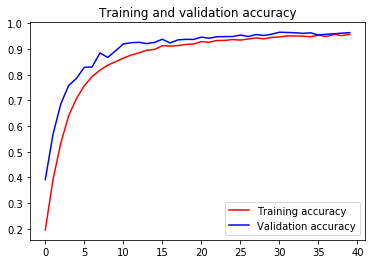

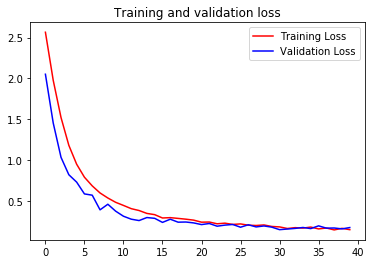

In [26]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [27]:
# Test the model
y_pred = model.predict(X_test)
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=list(map_characters.values())), sep='')


                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.94      0.97      0.95       123
  apu_nahasapeemapetilon       0.98      0.95      0.96        85
            bart_simpson       0.96      0.94      0.95       143
charles_montgomery_burns       0.97      0.97      0.97       194
            chief_wiggum       0.92      1.00      0.96       150
          comic_book_guy       0.94      0.88      0.91        68
          edna_krabappel       0.97      0.97      0.97        76
           homer_simpson       0.94      0.95      0.94       217
           kent_brockman       0.98      1.00      0.99        63
        krusty_the_clown       0.99      1.00      0.99       190
            lisa_simpson       0.99      0.94      0.96       174
           marge_simpson       0.99      0.96      0.98       164
     milhouse_van_houten       0.95      0.98      0.96       153
             moe_szyslak       0.95      0.96      0.95       175
        

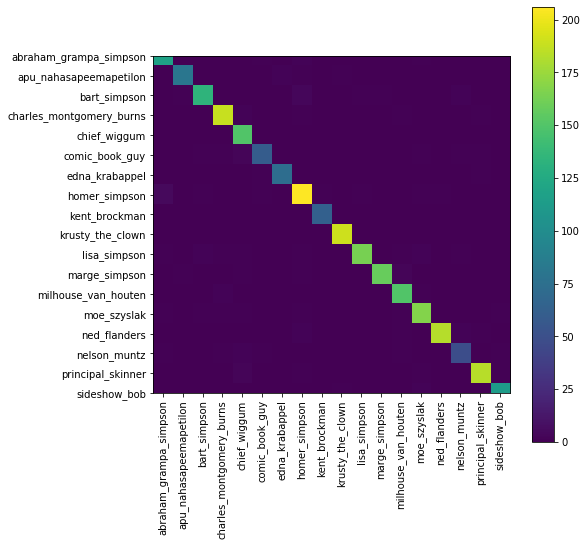

In [28]:
plt.figure(figsize=(8,8))
cnf_matrix = sklearn.metrics.confusion_matrix(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1))
classes = list(map_characters.values())
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

### Predicting an image

In [0]:
def file_predict(image_path, all_perc=False):
    image = cv2.imread(image_path)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    pic = cv2.resize(image, (64,64))
    a = model.predict_proba(pic.reshape(1, 64, 64,3))[0]
    if all_perc:
        print('\n'.join(['{} : {}%'.format(map_characters[i], round(k*100)) for i,k in sorted(enumerate(a), key=lambda x:x[1], reverse=True)]))
    else:
        return map_characters[np.argmax(a)].replace('_',' ').title()

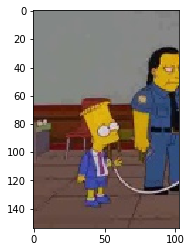

'Bart Simpson'

In [73]:
image_path = "/tmp/kaggle_simpson_testset/kaggle_simpson_testset/bart_simpson_48.jpg"
file_predict(image_path)

## Model save and load

In [78]:
# serialize weights to HDF5
model.save_weights("/tmp/model.h5")
print("Saved model to disk")

Saved model to disk


In [84]:
# load weights into new model
model.load_weights('/tmp/model.h5')
print("Loaded model from disk")
 
# evaluate loaded model on test data
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
score = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 96.40%


In [0]:
def file_predict(image_path, all_perc=False):
    image = cv2.imread(image_path)
    pic = cv2.resize(image, (64,64))
    a = model.predict_proba(pic.reshape(1, 64, 64,3))[0]
    if all_perc:
        print('\n'.join(['{} : {}%'.format(map_characters[i], round(k*100)) for i,k in sorted(enumerate(a), key=lambda x:x[1], reverse=True)]))
    else:
        return map_characters[np.argmax(a)].replace('_',' ').title()

In [86]:
image_path = "/tmp/kaggle_simpson_testset/kaggle_simpson_testset/bart_simpson_48.jpg"
file_predict(image_path)

'Bart Simpson'